In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
tf.constant(1.0)  # Trigger basic op
import logging
logging.getLogger('absl').setLevel(logging.ERROR)
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import ray
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import datetime
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
tf.config.optimizer.set_jit(True)   # keep it on for A100 performance
# If startup time is a hassle, temporarily set False while debugging shape/mask issues.


2025-10-29 14:37:02.791587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1761748625.873568    7649 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38367 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:04:00.0, compute capability: 8.0


In [3]:
%load_ext autoreload
%autoreload 2
from surface_coil_loader import load_full_dataset, load_split_datasets
from transformers import TransformerEncoder, TransformerDecoder
from CoilAutoEncoder import CoilAutoencoderModel, compute_masked_feature_stats

In [4]:
tfrecord_dir = Path("canon_surface_coil_tfrecords")

In [5]:
def build_coil_autoencoder(hp):
    encoder = TransformerEncoder(max_sets=6, features_per_set=100, name='coil', embed_dim=hp["embed_dim"],
        num_heads=hp["num_heads"], ff_dim=hp["ff_dim"], 
        num_sab_blocks=hp["sab_blocks"], dropout=hp["enc_dropout"])
    
    decoder = TransformerDecoder(name = 'coil', embed_dim=hp["embed_dim"], num_heads=hp["num_heads"], ff_dim=hp["ff_dim"],
        num_layers=hp["decoder_blocks"], max_sets=6, features_per_set=100, dropout=hp["dec_dropout"])
    
    autoencoder = CoilAutoencoderModel(encoder, decoder)
    return autoencoder, encoder, decoder

In [6]:
def build_model(hp):
    model, encoder, decoder = build_coil_autoencoder(hp)    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=3e-7, decay_steps=97000, 
                                                            warmup_target=hp['learning_rate'], warmup_steps=3000)
    optimizer = tf.keras.optimizers.Lion(learning_rate=lr_schedule, weight_decay=hp['weight_decay'], clipnorm=1.0)
    model.compile(optimizer=optimizer)
    return model, encoder, decoder

In [7]:
def prepare_callbacks(log_dir, model_name="coil_autoencoder"):
    return [
        TensorBoard(log_dir=log_dir),
        ModelCheckpoint(
            filepath=os.path.join(log_dir, f"{model_name}_best.keras"),
            save_best_only=True,
            monitor='val_loss'
        )
    ]

In [8]:
example_hp = {'batch_size': 512,
 'embed_dim': 256,
 'num_heads': 4,
 'ff_dim': 1024,
 'enc_dropout': 0.05,
 'dec_dropout': 0.05,
 'learning_rate': 9e-04,
 'weight_decay': 5e-3,
 'sab_blocks': 4,
 'decoder_blocks': 4}

In [9]:
class SaveBestSubmodels(tf.keras.callbacks.Callback):
    """
    Saves encoder/decoder when `monitor` improves. Works even if `restore_best_weights=True`
    is used on the top-level model (weights are shared).
    """
    def __init__(self, encoder, decoder, log_dir, monitor="val_loss", mode="min"):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.monitor = monitor
        self.log_dir = log_dir
        self.best = np.inf if mode == "min" else -np.inf
        self.cmp = (lambda a, b: a < b) if mode == "min" else (lambda a, b: a > b)
        self.save_dir = os.path.join(log_dir, "best")
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        if self.cmp(current, self.best):
            self.best = current
            # Save submodels
            enc_path = os.path.join(self.save_dir, "encoder.best.keras")
            dec_path = os.path.join(self.save_dir, "decoder.best.keras")
            self.encoder.save(enc_path)
            self.decoder.save(dec_path)
            # Persist the score for reference
            with open(os.path.join(self.save_dir, "best_metric.json"), "w") as f:
                json.dump({self.monitor: float(self.best), "epoch": int(epoch)}, f)

In [10]:
def train_coil_autoencoder(
    hp, train_ds, val_ds, epochs, log_root="logs", use_wandb=False,
    # --- Early stopping knobs ---
    early_stopping=True,
    es_monitor="val_loss",
    es_min_delta=0.0,
    es_patience=12,
    es_mode="min",
):
    
    def keep_coil_only(inputs, targets):
        return (
            {
                'coil_data': inputs['coil_data'],
                'coil_mask': inputs['coil_mask'],
            },
            targets['coil']
        )

    train_ds = train_ds.map(keep_coil_only, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds   = val_ds.map(keep_coil_only, num_parallel_calls=tf.data.AUTOTUNE)

    mu, sigma = compute_masked_feature_stats(train_ds, D=100, max_batches=200)

    model, encoder, decoder = build_model(hp)
    model.set_standardization_stats(mu, sigma)

    run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(log_root, f"{run_id}_trial")
    os.makedirs(log_dir, exist_ok=True)

    callbacks = prepare_callbacks(log_dir)

    # EarlyStopping (global, not per-epoch) — restore the best weights seen on val
    if early_stopping:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor=es_monitor,
                min_delta=es_min_delta,
                patience=es_patience,
                mode=es_mode,
                restore_best_weights=True
            )
        )
        # Save best encoder/decoder whenever the monitored metric improves
        callbacks.append(SaveBestSubmodels(
            encoder=encoder,
            decoder=decoder,
            log_dir=log_dir,
            monitor=es_monitor,
            mode=es_mode
        ))
        #Reduce LR
        # callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(
        #     monitor=es_monitor, 
        #     factor=0.5, 
        #     patience=es_patience//2),)

    if use_wandb:
        import wandb
        from wandb.keras import WandbCallback
        wandb.init(project="coil_autoencoder", config=hp)
        callbacks.append(WandbCallback(save_model=False))  # we save submodels ourselves

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    # Build submodels (ensures variables initialized)
    sample_inputs, _ = next(iter(train_ds))
    _ = encoder(sample_inputs, training=False)
    sample_latents, tokens = encoder(sample_inputs, training=False)
    _ = decoder([tokens, sample_latents], training=False)

    # Save "final" snapshot (early stopping may have restored best weights already)
    encoder.save(os.path.join(log_dir, "encoder.keras"))
    decoder.save(os.path.join(log_dir, "decoder.keras"))

    return history, encoder, decoder

In [ ]:
train_ds, val_ds, test_ds = load_split_datasets(tfrecord_dir, batch_size=example_hp["batch_size"])

history, encoder, decoder = train_coil_autoencoder(
    hp=example_hp,
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=200,
    log_root="coil_logs",
    use_wandb=False
)

2025-10-29 14:37:09.505838: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


μ  min/max: -27.7013149 21282386
σ  min/max: 0.001 1.56617582
σ  floored count: 14
Epoch 1/200


2025-10-29 14:39:11.616811: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c0250002140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-29 14:39:11.616860: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-10-29 14:39:11.636076: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
I0000 00:00:1761748751.695170    8588 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-29 14:39:26.900900: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator coil_autoencoder_model_1/coil_decoder_1/learned_query_decoder_1/assert_greater/Assert/Assert
2025-10-29 14:39:27.048420: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enabl

    311/Unknown 67s 36ms/step - loss: 1385645167607808.0000 - mae: 2092.3435 - masked_mse: 1385645167607808.0000 - std_mae: 2091948.0000

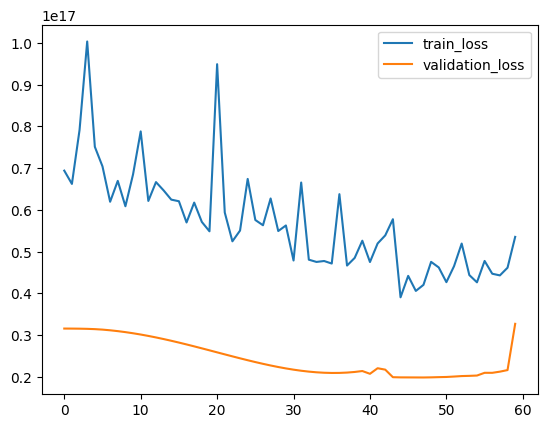

In [29]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

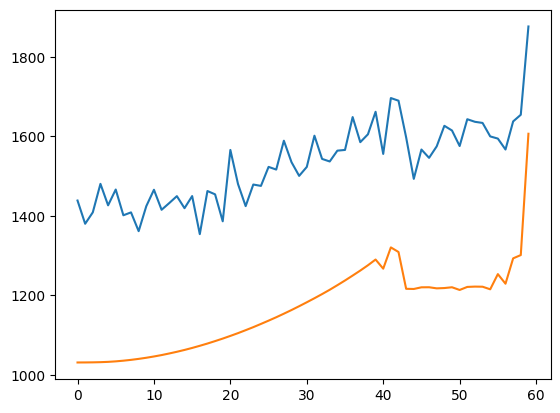

In [30]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.show()

In [17]:
batched_dataset = load_full_dataset(tfrecord_dir, batch_size = example_hp['batch_size'])

In [40]:
from transformers import SelfAttentionBlock, PoolingByMultiheadAttention
# encoder = tf.keras.models.load_model('coil_logs/20250812-152016_trial/encoder.keras', safe_mode=False)
encoder = tf.keras.models.load_model(
    "coil_logs/20250817-144615_trial/encoder.keras",
    custom_objects={"SelfAttentionBlock": SelfAttentionBlock, 
                    'PoolingByMultiheadAttention': PoolingByMultiheadAttention},
    safe_mode=False, compile=False
)

In [41]:
for batch, _ in batched_dataset.take(1):
    coil_data = batch["coil_data"]
    coil_mask = batch["coil_mask"]
    surface_data = batch["surface_data"]  # assumes surface is already included in parse_tfrecord_fn
    surface_mask = batch['surface_mask']

    coil_latents = encoder(
            {"coil_data": coil_data, "coil_mask": coil_mask},
            training=False
        )

AttributeError: Exception encountered when calling Lambda.call().

[1m'dict' object has no attribute 'ones_like'[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(64, 6), dtype=float32)
  • mask=None
  • training=False

In [14]:
import numpy as np
import tensorflow as tf

def _float_feature(value):
    """Returns a float_list from a tensor, numpy array, or list."""
    if isinstance(value, tf.Tensor):
        value = value.numpy()
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1).astype(np.float32)))

def _int64_feature(value):
    """Returns an int64_list from a tensor, numpy array, or list."""
    if isinstance(value, tf.Tensor):
        value = value.numpy()
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value.reshape(-1).astype(np.int64)))

def serialize_example(coil_data, coil_mask, surface_data, surface_mask, coil_latent):
    feature = {
        "coil_data": _float_feature(coil_data),         # (TOTAL_ROWS, FEATURES_PER_COIL)
        "coil_mask": _int64_feature(coil_mask),         # (MAX_COILS,)
        "surface_data": _float_feature(surface_data),   # (TOTAL_SETS, FEATURES_PER_SET)
        "surface_mask": _int64_feature(surface_mask),   # (TOTAL_SETS,)
        "coil_latent": _float_feature(coil_latent),     # (latent_dim,)
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


In [15]:
def write_latent_augmented_tfrecord(dataset, encoder, output_dir, max_records_per_file=10000):
    os.makedirs(output_dir, exist_ok=True)
    file_count = 0
    record_count = 0
    writer = None

    for batch, _ in tqdm(dataset, desc="Encoding & Writing"):
        coil_data = batch["coil_data"]
        coil_mask = batch["coil_mask"]
        surface_data = batch["surface_data"]  # assumes surface is already included in parse_tfrecord_fn
        surface_mask = batch['surface_mask']

        # Predict latents
        coil_latents = encoder(
            {"coil_data": coil_data, "coil_mask": coil_mask},
            training=False
        )

        for i in range(coil_data.shape[0]):
            if writer is None or record_count >= max_records_per_file:
                if writer:
                    writer.close()
                tfrecord_path = os.path.join(output_dir, f"augmented_{file_count:03d}.tfrecord")
                writer = tf.io.TFRecordWriter(tfrecord_path)
                file_count += 1
                record_count = 0

            serialized = serialize_example(coil_data[i], coil_mask[i], surface_data[i], surface_mask[i], coil_latents[i])
            writer.write(serialized)
            record_count += 1

    if writer:
        writer.close()


In [ ]:
latent_dir = Path('latents_tfrecords')
write_latent_augmented_tfrecord(batched_dataset, encoder, latent_dir)